# Data Load

In [1]:
import pandas as pd

df = pd.read_csv('../NLME.csv', low_memory=False)
unique_labels = df['label'].unique()
print("Unique labels:", unique_labels)
label_counts = df['label'].value_counts()
print("Value counts:\n", label_counts)

df2 = pd.read_csv('../parsed_events (20).csv', low_memory=False)

unique_labels = df2['label'].unique()
print("Unique labels:", unique_labels)
label_counts = df2['label'].value_counts()
print("Value counts:\n", label_counts)

FileNotFoundError: [Errno 2] No such file or directory: '../NLME.csv'

# Data Preprocess

In [2]:
df2.rename(columns={
    'target_file_name': 'TargetFilename',
    'event_id': 'EventID',
    'target_process_guid': 'TargetProcessGuid',
    'event_type': 'EventType',
    'target_image': 'TargetImage',
    'previous_creation_utc_time': 'PreviousCreationUtcTime',
    'destination_host_name': 'DestinationHostname',
    'company': 'Company',
    'description': 'Description',
    'product': 'Product',
    'integrity_level': 'IntegrityLevel',
    'creation_utc_time': 'CreationUtcTime',
    'start_function': 'StartFunction',
    'parent_process_id': 'ParentProcessGuid',
    'user': 'User',
    'logon_id': 'LogonId',
    'parent_process_id': 'ParentProcessId',
    'terminal_session_id': 'TerminalSessionId',
    'rule_name': 'RuleName',
    'target_object': 'TargetObject',
    'parent_process_guid': 'ParentProcessGuid'
    }, inplace=True)

In [3]:
important_columns = [
    'TargetFilename', 
    'EventID', 
    'TargetProcessGuid', 
    'EventType',
    'TargetImage', 
    'PreviousCreationUtcTime', 
    'DestinationHostname', 
    'Company', 
    'Description',
    'Product', 
    'IntegrityLevel', 
    'CreationUtcTime', 
    # 'StartFunction', 
    'ParentProcessGuid', 
    'User',
    'LogonId', 
    'ParentProcessId', 
    'TerminalSessionId', 
    'RuleName', 
    'TargetObject', 
    'label'
]

selected_df = df[important_columns]
selected_df2 = df2[important_columns]

## Data Split

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

def clean_and_encode(df):
    df = df.replace('-', np.nan)
    df = df.dropna(axis=1, how='all').drop_duplicates()
    le = LabelEncoder()
    filtered = []
    for col in df.columns:
        if col == 'label':
            continue
        if df[col].nunique() <= 25 and col != 'label':
            filtered.append(col)
            mask = df[col].isnull()
            df.loc[mask, col] = -1
            df.loc[~mask, col] = le.fit_transform(df[col][~mask])
        else:
            if df[col].dtype == "object":
                df[col] = df[col].str.len()
            df[col] = df[col].fillna(-1)
    return df, filtered

def preprocess_data_3(df, df2):
    df['label'] = df['label'].replace({1: -1, 0: 1})
    df2['label'] = df2['label'].replace({1: -1, 0: 1})
    df, filteredColumn = clean_and_encode(df)
    df2, _ = clean_and_encode(df2)
    
    benign_df = df[df['label'] == 1]
    malware_df = df[df['label'] == -1]
    train_df = benign_df.iloc[malware_df.shape[0]:]
    test_df = pd.concat([benign_df.iloc[:malware_df.shape[0]], malware_df])

    benign_df2 = df2[df2['label'] == 1]
    malware_df2 = df2[df2['label'] == -1]
    
    print(filteredColumn)

    train_means = benign_df[filteredColumn].mean()
    test_means = benign_df2[filteredColumn].mean()

    abs_diff = (train_means - test_means).abs()
    df_diff = pd.DataFrame({
        "Train means": train_means,
        "Test means": test_means,
        "Diff": abs_diff
    }).sort_values(by="Diff", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(len(filteredColumn)), y=train_means.values, label="Train Benign")
    sns.lineplot(x=range(len(filteredColumn)), y=test_means.values, label="Test Benign")
    plt.xticks(range(len(filteredColumn)), filteredColumn, rotation=90)
    plt.title("Feature Distribution Shift (Benign)")
    plt.tight_layout()
    plt.show()

    benign_shuffled = benign_df2.sample(frac=1, random_state=42).reset_index(drop=True)
    malware_shuffled = malware_df2.sample(frac=1, random_state=123).reset_index(drop=True)  # Different seed
    
    min_size = min(len(benign_shuffled), len(malware_shuffled))
    benign_for_test = benign_shuffled.iloc[:min_size]
    malware_for_test = malware_shuffled.iloc[:min_size]
    
    benign_test_chunks = np.array_split(benign_for_test, 10)
    malware_test_chunks = np.array_split(malware_for_test, 10)
    
    test_df2 = pd.concat([benign_for_test, malware_for_test])
    test_chunks = []
    for i in range(10):
        combined_chunk = pd.concat([benign_test_chunks[i], malware_test_chunks[i]], ignore_index=True)
        combined_chunk = combined_chunk.sample(frac=1, random_state=i*10).reset_index(drop=True)
        test_chunks.append(combined_chunk)
        print(f"Test chunk {i+1}: {len(combined_chunk)} samples, "
              f"benign: {len(combined_chunk[combined_chunk['label']==1])}, "
              f"malware: {len(combined_chunk[combined_chunk['label']==-1])}")
    
    remaining_benign = benign_shuffled.iloc[min_size:] if len(benign_shuffled) > min_size else benign_shuffled
    
    train_chunks = []
    for i in range(10):
        if len(remaining_benign) > 1000:  # If we have enough data
            train_sample = remaining_benign.sample(n=min(len(remaining_benign), 5000), 
                                                 random_state=i*100, 
                                                 replace=False).reset_index(drop=True)
        else:
            train_sample = remaining_benign.sample(n=5000, 
                                                 random_state=i*100, 
                                                 replace=True).reset_index(drop=True)
        
        train_chunks.append(train_sample)
        print(f"Train chunk {i+1}: {len(train_sample)} benign samples")
    
    print("\nVerifying chunk diversity:")
    for i in range(min(5, len(train_chunks)-1)):
        similarity = len(pd.merge(train_chunks[i], train_chunks[i+1], how='inner')) / len(train_chunks[i])
        print(f"Train chunks {i+1} and {i+2} similarity: {similarity:.2%}")
    
    for i in range(min(5, len(test_chunks)-1)):
        similarity = len(pd.merge(test_chunks[i], test_chunks[i+1], how='inner')) / len(test_chunks[i])
        print(f"Test chunks {i+1} and {i+2} similarity: {similarity:.2%}")

    return df, train_df, test_df, df2, train_chunks, test_chunks, remaining_benign, pd.concat([benign_df2.iloc[:min_size], malware_df2.iloc[:min_size]])


/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_11151/3903420739.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].replace({1: -1, 0: 1})
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_11151/3903420739.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label'] = df2['label'].replace({1: -1, 0: 1})


['EventID', 'EventType', 'TargetImage', 'DestinationHostname', 'IntegrityLevel', 'User', 'TerminalSessionId', 'RuleName']


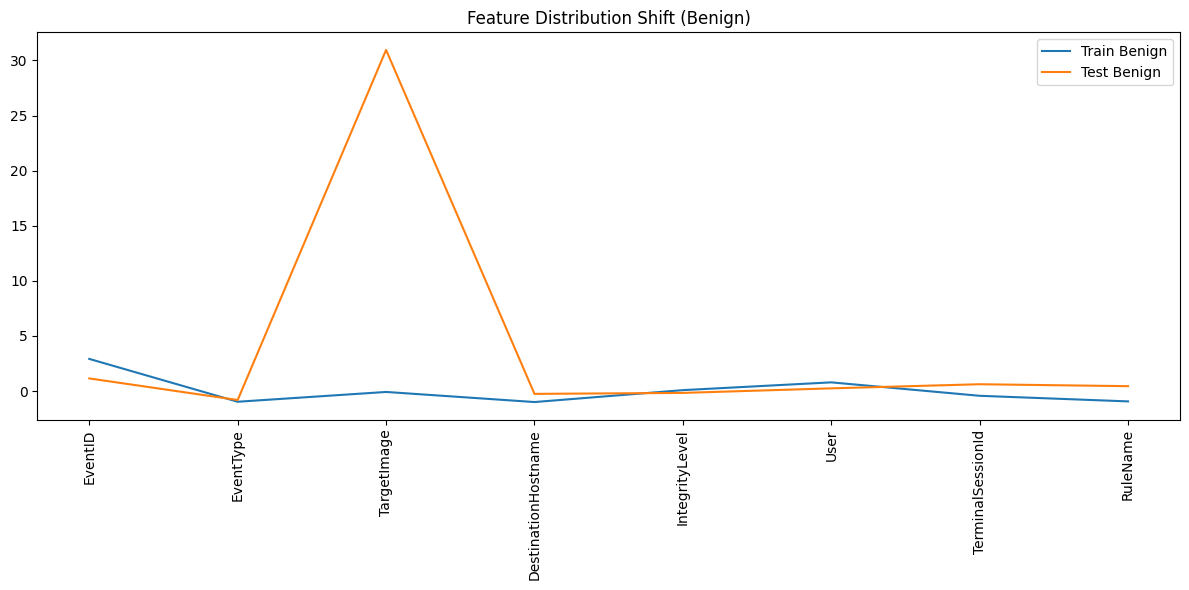

/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Test chunk 1: 14044 samples, benign: 7022, malware: 7022
Test chunk 2: 14044 samples, benign: 7022, malware: 7022
Test chunk 3: 14044 samples, benign: 7022, malware: 7022
Test chunk 4: 14042 samples, benign: 7021, malware: 7021
Test chunk 5: 14042 samples, benign: 7021, malware: 7021
Test chunk 6: 14042 samples, benign: 7021, malware: 7021
Test chunk 7: 14042 samples, benign: 7021, malware: 7021
Test chunk 8: 14042 samples, benign: 7021, malware: 7021
Test chunk 9: 14042 samples, benign: 7021, malware: 7021
Test chunk 10: 14042 samples, benign: 7021, malware: 7021
Train chunk 1: 5000 benign samples
Train chunk 2: 5000 benign samples
Train chunk 3: 5000 benign samples
Train chunk 4: 5000 benign samples
Train chunk 5: 5000 benign samples
Train chunk 6: 5000 benign samples
Train chunk 7: 5000 benign samples
Train chunk 8: 5000 benign samples
Train chunk 9: 5000 benign samples
Train chunk 10: 5000 benign samples

Verifying chunk diversity:
Train chunks 1 and 2 similarity: 439.66%
Train chu

In [5]:
ndf, train_df, test_df, ndf2, train_chunks, test_chunks, train_df2, test_df2 = preprocess_data_3(selected_df, selected_df2)

In [ ]:
def count_stats(df, outlier=1, label=1):
    tmp = df.apply(lambda x : True if x['outlier'] == outlier and x['label'] == label else False, axis = 1)
    return len(tmp[tmp == True].index)

def test_model(clf, df):
    X_test = df.drop('label', axis=1)
    outliers_predicted = clf.predict(X_test)
    new_df = df.copy()
    new_df['outlier'] = outliers_predicted
    tp = count_stats(new_df, outlier=-1, label=-1)
    fn = count_stats(new_df, outlier=1, label=-1)
    fp = count_stats(new_df, outlier=-1, label=1)    
    tn = count_stats(new_df, outlier=1, label=1)

    # conf_matrix = pd.DataFrame(
    #     [[tp, fn],
    #      [fp, tn]],
    #     columns=['Actual outlier', 'Actual inlier'],
    #     index=['Predicted outlier', 'Predicted inlier']
    # )

    # plt.figure(figsize=(6, 4))
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='grey_r')
    # plt.title('Confusion Matrix')
    # plt.show()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * (recall * precision) / (precision + recall)
    return new_df, recall, precision, f1, tp, fn, fp, tn

# LOF

### PCA

In [12]:
import time
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import ParameterGrid
import joblib
import pandas as pd

def test_model_wrapper(model, test_data):
    """
    Wrapper function for your existing test_model function
    Replace this with your actual test_model implementation
    """
    # Assuming test_model returns (predictions, recall, precision, f1)
    # You'll need to replace this with your actual test_model function
    pass

def evaluate_lof_parameters(train_df, test_df, test_df2=None):
    """
    Comprehensive parameter selection for LocalOutlierFactor
    """
    
    # Define parameter grid for testing
    param_grid = {
        'n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [20, 30, 40, 50],
        'contamination': [0.1, 0.2, 0.3, 0.4, 0.5],
        'novelty': [True]  # Keep True for your use case
    }
    
    # For quick testing, use a smaller grid
    quick_param_grid = {
        'n_neighbors': [10, 20, 30],
        'algorithm': ['auto', 'kd_tree'],
        'leaf_size': [30, 40],
        'contamination': [0.2, 0.3, 0.4],
        'novelty': [True]
    }
    
    X_train = train_df.drop('label', axis=1)
    results = []
    
    print("Starting parameter grid search...")
    print(f"Total combinations to test: {len(list(ParameterGrid(quick_param_grid)))}")
    
    for i, params in enumerate(ParameterGrid(quick_param_grid)):
        try:
            print(f"\nTesting combination {i+1}: {params}")
            
            # Create and train model
            start_train = time.time()
            lof = LocalOutlierFactor(**params)
            lof.fit(X_train)
            train_time = time.time() - start_train
            
            # Test on first dataset
            start_test1 = time.time()
            _, recall_1, precision_1, f1_1 = test_model(lof, test_df)
            test1_time = time.time() - start_test1
            
            # Test on second dataset if provided
            if test_df2 is not None:
                start_test2 = time.time()
                _, recall_2, precision_2, f1_2 = test_model(lof, test_df2)
                test2_time = time.time() - start_test2
            else:
                recall_2 = precision_2 = f1_2 = test2_time = 0
            
            # Store results
            result = {
                'params': params,
                'train_time': train_time,
                'test1_precision': precision_1,
                'test1_recall': recall_1,
                'test1_f1': f1_1,
                'test1_time': test1_time,
                'test2_precision': precision_2,
                'test2_recall': recall_2,
                'test2_f1': f1_2,
                'test2_time': test2_time,
                'avg_f1': (f1_1 + f1_2) / 2 if test_df2 is not None else f1_1
            }
            results.append(result)
            
            print(f"Test1 - Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1: {f1_1:.4f}")
            if test_df2 is not None:
                print(f"Test2 - Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1: {f1_2:.4f}")
            
        except Exception as e:
            print(f"Error with params {params}: {str(e)}")
            continue
    
    return results

def analyze_results(results):
    """
    Analyze and display the best parameter combinations
    """
    if not results:
        print("No results to analyze!")
        return None
    
    # Convert to DataFrame for easier analysis
    df_results = []
    for result in results:
        row = result['params'].copy()
        row.update({k: v for k, v in result.items() if k != 'params'})
        df_results.append(row)
    
    df = pd.DataFrame(df_results)
    
    print("\n" + "="*80)
    print("PARAMETER ANALYSIS RESULTS")
    print("="*80)
    
    # Best overall F1 score
    best_idx = df['avg_f1'].idxmax()
    best_result = results[best_idx]
    
    print(f"\nBEST OVERALL PARAMETERS (Highest Average F1: {best_result['avg_f1']:.4f}):")
    print("-" * 60)
    for param, value in best_result['params'].items():
        print(f"{param}: {value}")
    
    print(f"\nPerformance:")
    print(f"Test1 - Precision: {best_result['test1_precision']:.4f}, Recall: {best_result['test1_recall']:.4f}, F1: {best_result['test1_f1']:.4f}")
    print(f"Test2 - Precision: {best_result['test2_precision']:.4f}, Recall: {best_result['test2_recall']:.4f}, F1: {best_result['test2_f1']:.4f}")
    print(f"Training time: {best_result['train_time']:.4f}s")
    
    # Top 5 combinations
    print(f"\nTOP 5 PARAMETER COMBINATIONS:")
    print("-" * 60)
    top_5 = df.nlargest(5, 'avg_f1')
    for i, (idx, row) in enumerate(top_5.iterrows()):
        print(f"\n{i+1}. F1: {row['avg_f1']:.4f}")
        print(f"   n_neighbors: {row['n_neighbors']}, algorithm: {row['algorithm']}")
        print(f"   leaf_size: {row['leaf_size']}, contamination: {row['contamination']}")
    
    # Parameter impact analysis
    print(f"\nPARAMETER IMPACT ANALYSIS:")
    print("-" * 60)
    
    for param in ['n_neighbors', 'algorithm', 'leaf_size', 'contamination']:
        if param in df.columns:
            param_analysis = df.groupby(param)['avg_f1'].agg(['mean', 'std', 'count'])
            print(f"\n{param.upper()}:")
            for value, stats in param_analysis.iterrows():
                print(f"  {value}: Mean F1={stats['mean']:.4f} (±{stats['std']:.4f}), Count={stats['count']}")
    
    return best_result

# Main execution function
def optimize_lof_parameters(train_df, test_df, test_df2=None):
    """
    Main function to optimize LOF parameters
    """
    print("LocalOutlierFactor Parameter Optimization")
    print("="*50)
    
    # Run parameter search
    results = evaluate_lof_parameters(train_df, test_df, test_df2)
    
    # Analyze results
    best_params = analyze_results(results)
    
    if best_params:
        # Train final model with best parameters
        print(f"\n" + "="*80)
        print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
        print("="*80)
        
        X_train = train_df.drop('label', axis=1)
        final_lof = LocalOutlierFactor(**best_params['params'])
        final_lof.fit(X_train)
        
        # Save the best model
        joblib.dump(final_lof, 'lof_optimized.joblib')
        print("Best model saved as 'lof_optimized.joblib'")
        
        return final_lof, best_params
    
    return None, None

# Alternative: Quick parameter suggestions based on common practices
def get_parameter_suggestions():
    """
    Returns suggested parameter combinations based on common practices
    """
    suggestions = {
        'small_datasets': {
            'n_neighbors': [5, 10, 15],
            'algorithm': 'auto',
            'leaf_size': 30,
            'contamination': 0.1,
            'novelty': True
        },
        'medium_datasets': {
            'n_neighbors': [15, 20, 25],
            'algorithm': 'kd_tree',
            'leaf_size': 30,
            'contamination': 0.2,
            'novelty': True
        },
        'large_datasets': {
            'n_neighbors': [20, 30, 40],
            'algorithm': 'kd_tree',
            'leaf_size': 40,
            'contamination': 0.3,
            'novelty': True
        },
        'high_dimensional': {
            'n_neighbors': [10, 15, 20],
            'algorithm': 'brute',
            'leaf_size': 20,
            'contamination': 0.2,
            'novelty': True
        }
    }
    
    print("PARAMETER SUGGESTIONS BY DATASET TYPE:")
    print("="*50)
    for dataset_type, params in suggestions.items():
        print(f"\n{dataset_type.upper().replace('_', ' ')}:")
        for param, value in params.items():
            print(f"  {param}: {value}")
    
    return suggestions

# Example usage:
if __name__ == "__main__":
    # Method 1: Full grid search (recommended)
    final_model, best_params = optimize_lof_parameters(train_df, test_df, test_df2)
    
    # Method 2: Quick parameter suggestions
    suggestions = get_parameter_suggestions()
    
    # Method 3: Manual testing with specific combinations
    test_combinations = [
        {'n_neighbors': 20, 'algorithm': 'auto', 'leaf_size': 30, 'contamination': 0.2, 'novelty': True},
        {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 40, 'contamination': 0.3, 'novelty': True},
        {'n_neighbors': 25, 'algorithm': 'ball_tree', 'leaf_size': 20, 'contamination': 0.1, 'novelty': True},
    ]
    
    print(f"\nTEST COMBINATIONS FOR MANUAL EVALUATION:")
    print("-" * 50)
    for i, combo in enumerate(test_combinations, 1):
        print(f"{i}. {combo}")

LocalOutlierFactor Parameter Optimization
Starting parameter grid search...
Total combinations to test: 36

Testing combination 1: {'algorithm': 'auto', 'contamination': 0.2, 'leaf_size': 30, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 2: {'algorithm': 'auto', 'contamination': 0.2, 'leaf_size': 30, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 3: {'algorithm': 'auto', 'contamination': 0.2, 'leaf_size': 30, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 4: {'algorithm': 'auto', 'contamination': 0.2, 'leaf_size': 40, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 5: {'algorithm': 'auto', 'contamination': 0.2, 'leaf_size': 40, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 6: {'algorithm': 'auto', 'contamination': 0.2, 'leaf_size': 40, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 7: {'algorithm': 'auto', 'contamination': 0.3, 'leaf_size': 30, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 8: {'algorithm': 'auto', 'contamination': 0.3, 'leaf_size': 30, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 9: {'algorithm': 'auto', 'contamination': 0.3, 'leaf_size': 30, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 10: {'algorithm': 'auto', 'contamination': 0.3, 'leaf_size': 40, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 11: {'algorithm': 'auto', 'contamination': 0.3, 'leaf_size': 40, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 12: {'algorithm': 'auto', 'contamination': 0.3, 'leaf_size': 40, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 13: {'algorithm': 'auto', 'contamination': 0.4, 'leaf_size': 30, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 14: {'algorithm': 'auto', 'contamination': 0.4, 'leaf_size': 30, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 15: {'algorithm': 'auto', 'contamination': 0.4, 'leaf_size': 30, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 16: {'algorithm': 'auto', 'contamination': 0.4, 'leaf_size': 40, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 17: {'algorithm': 'auto', 'contamination': 0.4, 'leaf_size': 40, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 18: {'algorithm': 'auto', 'contamination': 0.4, 'leaf_size': 40, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 19: {'algorithm': 'kd_tree', 'contamination': 0.2, 'leaf_size': 30, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 20: {'algorithm': 'kd_tree', 'contamination': 0.2, 'leaf_size': 30, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 21: {'algorithm': 'kd_tree', 'contamination': 0.2, 'leaf_size': 30, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 22: {'algorithm': 'kd_tree', 'contamination': 0.2, 'leaf_size': 40, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 23: {'algorithm': 'kd_tree', 'contamination': 0.2, 'leaf_size': 40, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 24: {'algorithm': 'kd_tree', 'contamination': 0.2, 'leaf_size': 40, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 25: {'algorithm': 'kd_tree', 'contamination': 0.3, 'leaf_size': 30, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 26: {'algorithm': 'kd_tree', 'contamination': 0.3, 'leaf_size': 30, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 27: {'algorithm': 'kd_tree', 'contamination': 0.3, 'leaf_size': 30, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 28: {'algorithm': 'kd_tree', 'contamination': 0.3, 'leaf_size': 40, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 29: {'algorithm': 'kd_tree', 'contamination': 0.3, 'leaf_size': 40, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 30: {'algorithm': 'kd_tree', 'contamination': 0.3, 'leaf_size': 40, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 31: {'algorithm': 'kd_tree', 'contamination': 0.4, 'leaf_size': 30, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 32: {'algorithm': 'kd_tree', 'contamination': 0.4, 'leaf_size': 30, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 33: {'algorithm': 'kd_tree', 'contamination': 0.4, 'leaf_size': 30, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

Testing combination 34: {'algorithm': 'kd_tree', 'contamination': 0.4, 'leaf_size': 40, 'n_neighbors': 10, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8556, Recall: 0.6719, F1: 0.7527
Test2 - Precision: 0.5178, Recall: 0.9959, F1: 0.6813

Testing combination 35: {'algorithm': 'kd_tree', 'contamination': 0.4, 'leaf_size': 40, 'n_neighbors': 20, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8347, Recall: 0.7036, F1: 0.7636
Test2 - Precision: 0.5032, Recall: 0.9998, F1: 0.6695

Testing combination 36: {'algorithm': 'kd_tree', 'contamination': 0.4, 'leaf_size': 40, 'n_neighbors': 30, 'novelty': True}


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682

PARAMETER ANALYSIS RESULTS

BEST OVERALL PARAMETERS (Highest Average F1: 0.7247):
------------------------------------------------------------
algorithm: auto
contamination: 0.2
leaf_size: 30
n_neighbors: 30
novelty: True

Performance:
Test1 - Precision: 0.8213, Recall: 0.7448, F1: 0.7812
Test2 - Precision: 0.5019, Recall: 0.9993, F1: 0.6682
Training time: 0.3090s

TOP 5 PARAMETER COMBINATIONS:
------------------------------------------------------------

1. F1: 0.7247
   n_neighbors: 30, algorithm: auto
   leaf_size: 30, contamination: 0.2

2. F1: 0.7247
   n_neighbors: 30, algorithm: auto
   leaf_size: 40, contamination: 0.2

3. F1: 0.7247
   n_neighbors: 30, algorithm: auto
   leaf_size: 30, contamination: 0.3

4. F1: 0.7247
   n_neighbors: 30, algorithm: auto
   leaf_size: 40, contamination: 0.3

5. F1: 0.7247
   n_neighbors: 30, algorithm: auto
   leaf_size: 30, contaminati

### Real LOF

/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Data training:
Precision: 0.811, Recall: 0.740, F1-score: 0.774
Time execution: 0.3899


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Data testing:
Precision: 0.500, Recall: 1.000, F1-score: 0.667
Time execution: 3.8942


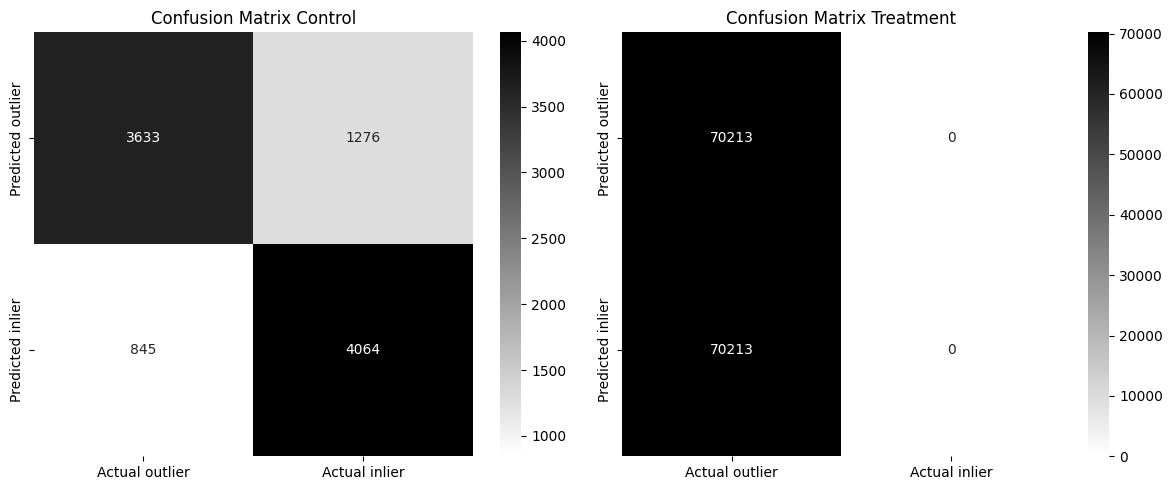

In [8]:
import time
from sklearn.neighbors import LocalOutlierFactor
import joblib


lof = LocalOutlierFactor(n_neighbors=30, algorithm='auto', leaf_size=30, contamination=0.2, novelty=True)
# lof = LocalOutlierFactor(n_neighbors=5, algorithm='kd_tree', leaf_size=30, contamination=0.4, novelty=True)
X_train = train_df.drop('label', axis=1)
lof.fit(X_train)
joblib.dump(lof, 'lof.joblib')

iso = joblib.load('lof.joblib')

start = time.time()
_, recall, precision, f1, tp, fn, fp, tn = test_model(iso, test_df)
end = time.time()
elapsed = end-start

print('Data training:')
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")
print(f"Time execution: {elapsed:.4f}")

start = time.time()
_, recall_2, precision_2, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(iso, test_df2)
end = time.time()
elapsed = end-start

print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f"Time execution: {elapsed:.4f}")

conf_matrix = pd.DataFrame(
    [[tp, fn],
    [fp, tn]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='grey_r', ax=axs[0])
axs[0].set_title("Confusion Matrix Control")
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs[1])
axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.savefig("comparison_heatmaps.png")
plt.show()

# Retraining

### a. Concat old + new data (50:50)

In [ ]:
import time
from sklearn.neighbors import LocalOutlierFactor
import joblib


retrain_df = pd.concat([train_df2.iloc[:train_df.shape[0], :], train_df])
lof = LocalOutlierFactor(n_neighbors=30, algorithm='auto', leaf_size=30, contamination=0.2, novelty=True)
X_train = retrain_df.drop('label', axis=1)
lof.fit(X_train)
joblib.dump(lof, 'lofretrain.joblib')

['lofretrain.joblib']

/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Data training:
Precision: 0.841, Recall: 0.597, F1-score: 0.698
Time execution: 0.4832


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Data testing:
Precision: 0.696, Recall: 0.673, F1-score: 0.684
Time execution: 5.2255


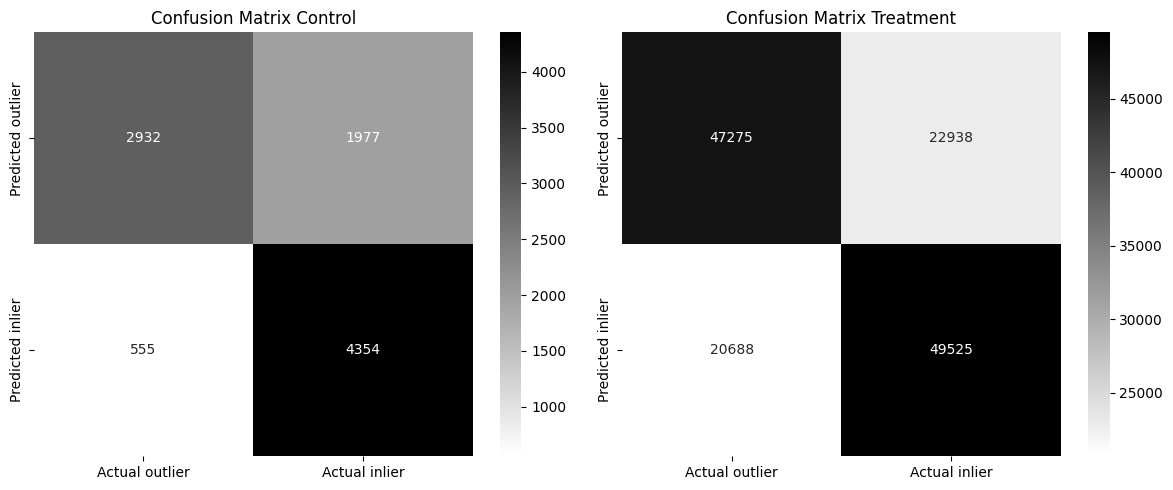

In [10]:
lof = joblib.load('lofretrain.joblib')

start = time.time()
_, recall, precision, f1, tp, fn, fp, tn = test_model(lof, test_df)
end = time.time()
elapsed = end-start

print('Data training:')
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")
print(f"Time execution: {elapsed:.4f}")

start = time.time()
_, recall_2, precision_2, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(lof, test_df2)
end = time.time()
elapsed = end-start

print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f"Time execution: {elapsed:.4f}")

conf_matrix = pd.DataFrame(
    [[tp, fn],
    [fp, tn]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='grey_r', ax=axs[0])
axs[0].set_title("Confusion Matrix Control")
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs[1])
axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.show()

### b. Full model replacement with new data

/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Data testing:
Precision: 0.696, Recall: 0.437, F1-score: 0.537
Time execution: 5.9502


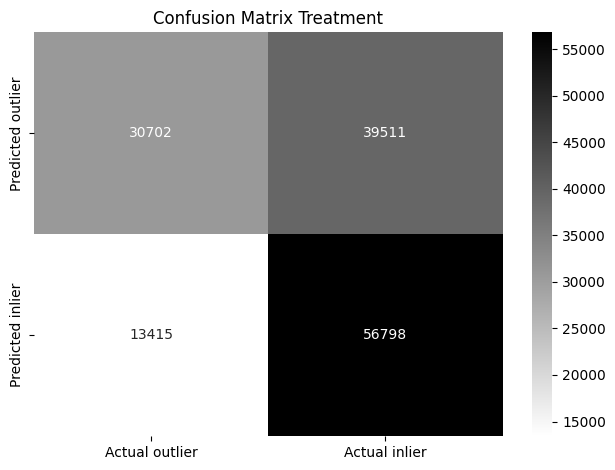

In [11]:
lof = LocalOutlierFactor(n_neighbors=30, algorithm='auto', leaf_size=30, contamination=0.2, novelty=True)
X_train = train_df2.drop('label', axis=1)
lof.fit(X_train)
joblib.dump(lof, 'lof2.joblib')

lof = joblib.load('lof2.joblib')
start = time.time()
_, recall_2, precision_2, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(lof, test_df2)
end = time.time()
elapsed = end-start

print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f"Time execution: {elapsed:.4f}")


conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs= plt.subplots()
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs)
axs.set_title("Confusion Matrix Treatment")
# sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs[1])
# axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.show()

### Continuous retraining

In [11]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
import joblib

previous_results = None

for i in range(10):
    print(f'Data testing {i+1}:')
    
    training_data = train_chunks[i][train_chunks[i]['label'] == 1].copy()
    print(f"Training on {len(training_data)} samples")
    
    lof = LocalOutlierFactor(n_neighbors=30, algorithm='auto', leaf_size=30, contamination=0.2, novelty=True)
    X_train = training_data.drop('label', axis=1)
    lof.fit(X_train)
    joblib.dump(lof, f'lofretrain{i+1}.joblib')
    
    iso = joblib.load(f'lofretrain{i+1}.joblib')
    
    test_data = test_chunks[i].copy()
    print(f"Testing on {len(test_data)} samples")
    
    start = time.time()
    current_results, recall_2, precision_2, f1_2 = test_model(lof, test_data)
    end = time.time()
    elapsed = end-start
    print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
    print(f"Time execution: {elapsed:.4f}")

    
    if previous_results is not None:
        print("\n--- McNemar Test Analysis ---")
        
        if 'outlier' in current_results.columns and 'outlier' in previous_results.columns:
            both_anomaly = len(current_results[
                (current_results['outlier'] == -1) & 
                (previous_results['outlier'] == -1)
            ])
            
            curr_anom_prev_norm = len(current_results[
                (current_results['outlier'] == -1) & 
                (previous_results['outlier'] == 1)
            ])
            
            curr_norm_prev_anom = len(current_results[
                (current_results['outlier'] == 1) & 
                (previous_results['outlier'] == -1)
            ])
            
            both_normal = len(current_results[
                (current_results['outlier'] == 1) & 
                (previous_results['outlier'] == 1)
            ])
            
            print(f"Agreement - Both anomaly: {both_anomaly}")
            print(f"Agreement - Both normal: {both_normal}")
            print(f"Disagreement - Current anomaly, Previous normal: {curr_anom_prev_norm}")
            print(f"Disagreement - Current normal, Previous anomaly: {curr_norm_prev_anom}")
            
            total_disagreements = curr_anom_prev_norm + curr_norm_prev_anom
            total_samples = both_anomaly + both_normal + total_disagreements
            agreement_rate = (both_anomaly + both_normal) / total_samples
            
            print(f"Total disagreements: {total_disagreements}")
            print(f"Agreement rate: {agreement_rate:.3f}")
            
            if total_disagreements > 0:
                mcnemar_table = np.array([
                    [both_anomaly, curr_anom_prev_norm], 
                    [curr_norm_prev_anom, both_normal]
                ])
                
                print(f"McNemar Table:")
                print(f"                Previous Model")
                print(f"               Anomaly  Normal")
                print(f"Current Anomaly   {both_anomaly:4d}    {curr_anom_prev_norm:4d}")
                print(f"        Normal    {curr_norm_prev_anom:4d}    {both_normal:4d}")
                
                try:
                    result = mcnemar(mcnemar_table, exact=False, correction=True)
                    print(f"McNemar Statistic: {result.statistic:.4f}")
                    print(f"McNemar p-value: {result.pvalue}")
                    
                    if result.pvalue < 0.001:
                        print("*** Highly significant difference between models (p < 0.001)")
                    elif result.pvalue < 0.01:
                        print("** Significant difference between models (p < 0.01)")
                    elif result.pvalue < 0.05:
                        print("* Marginally significant difference between models (p < 0.05)")
                    else:
                        print("No significant difference between models (p >= 0.05)")
                        
                except Exception as e:
                    print(f"Error in McNemar test: {e}")
            else:
                print("No disagreements between models - McNemar test not applicable")
        else:
            print("Missing 'outlier' column in results - cannot perform McNemar test")
    elif previous_results is not None:
        print(f"Warning: Result sizes don't match - Current: {len(current_results)}, Previous: {len(previous_results)}")
    else:
        print("First iteration - no previous model to compare")
    
    previous_results = current_results.copy()
    
    print("-" * 80)
    print()

print("Model retraining and comparison completed!")

Data testing 1:
Training on 5000 samples
Testing on 14044 samples


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Precision: 0.743, Recall: 0.672, F1-score: 0.706
Time execution: 0.1920
First iteration - no previous model to compare
--------------------------------------------------------------------------------

Data testing 2:
Training on 5000 samples
Testing on 14044 samples


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Precision: 0.734, Recall: 0.631, F1-score: 0.678
Time execution: 0.1926

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2764
Agreement - Both normal: 4420
Disagreement - Current anomaly, Previous normal: 3274
Disagreement - Current normal, Previous anomaly: 3586
Total disagreements: 6860
Agreement rate: 0.512
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   2764    3274
        Normal    3586    4420
McNemar Statistic: 14.0993
McNemar p-value: 0.0001734109644924768
*** Highly significant difference between models (p < 0.001)
--------------------------------------------------------------------------------

Data testing 3:
Training on 5000 samples
Testing on 14044 samples


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Precision: 0.720, Recall: 0.592, F1-score: 0.650
Time execution: 0.1893

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2490
Agreement - Both normal: 4715
Disagreement - Current anomaly, Previous normal: 3291
Disagreement - Current normal, Previous anomaly: 3548
Total disagreements: 6839
Agreement rate: 0.513
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   2490    3291
        Normal    3548    4715
McNemar Statistic: 9.5827
McNemar p-value: 0.00196420674724043
** Significant difference between models (p < 0.01)
--------------------------------------------------------------------------------

Data testing 4:
Training on 5000 samples
Testing on 14042 samples


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_69077/4239757856.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_anomaly = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_69077/4239757856.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_anom_prev_norm = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_69077/4239757856.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_norm_prev_anom = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_69077/4239757856.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_normal = len(c

Precision: 0.742, Recall: 0.651, F1-score: 0.694
Time execution: 0.1929

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2560
Agreement - Both normal: 4660
Disagreement - Current anomaly, Previous normal: 3603
Disagreement - Current normal, Previous anomaly: 3219
Total disagreements: 6822
Agreement rate: 0.514
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   2560    3603
        Normal    3219    4660
McNemar Statistic: 21.5023
McNemar p-value: 3.533961821357907e-06
*** Highly significant difference between models (p < 0.001)
--------------------------------------------------------------------------------

Data testing 5:
Training on 5000 samples
Testing on 14042 samples


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Precision: 0.722, Recall: 0.601, F1-score: 0.656
Time execution: 0.1934

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2630
Agreement - Both normal: 4665
Disagreement - Current anomaly, Previous normal: 3214
Disagreement - Current normal, Previous anomaly: 3533
Total disagreements: 6747
Agreement rate: 0.520
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   2630    3214
        Normal    3533    4665
McNemar Statistic: 14.9880
McNemar p-value: 0.00010819733018705105
*** Highly significant difference between models (p < 0.001)
--------------------------------------------------------------------------------

Data testing 6:
Training on 5000 samples
Testing on 14042 samples


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Precision: 0.718, Recall: 0.575, F1-score: 0.638
Time execution: 0.1949

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2339
Agreement - Both normal: 4918
Disagreement - Current anomaly, Previous normal: 3280
Disagreement - Current normal, Previous anomaly: 3505
Total disagreements: 6785
Agreement rate: 0.517
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   2339    3280
        Normal    3505    4918
McNemar Statistic: 7.3951
McNemar p-value: 0.0065400467952847095
** Significant difference between models (p < 0.01)
--------------------------------------------------------------------------------

Data testing 7:
Training on 5000 samples
Testing on 14042 samples


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Precision: 0.732, Recall: 0.602, F1-score: 0.660
Time execution: 0.1937

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2375
Agreement - Both normal: 5026
Disagreement - Current anomaly, Previous normal: 3397
Disagreement - Current normal, Previous anomaly: 3244
Total disagreements: 6641
Agreement rate: 0.527
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   2375    3397
        Normal    3244    5026
McNemar Statistic: 3.4790
McNemar p-value: 0.06215250838783485
No significant difference between models (p >= 0.05)
--------------------------------------------------------------------------------

Data testing 8:
Training on 5000 samples
Testing on 14042 samples


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Precision: 0.738, Recall: 0.627, F1-score: 0.678
Time execution: 0.1883

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2474
Agreement - Both normal: 4777
Disagreement - Current anomaly, Previous normal: 3493
Disagreement - Current normal, Previous anomaly: 3298
Total disagreements: 6791
Agreement rate: 0.516
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   2474    3493
        Normal    3298    4777
McNemar Statistic: 5.5420
McNemar p-value: 0.018564919263931827
* Marginally significant difference between models (p < 0.05)
--------------------------------------------------------------------------------

Data testing 9:
Training on 5000 samples
Testing on 14042 samples


/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Precision: 0.745, Recall: 0.638, F1-score: 0.688
Time execution: 0.1899

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2571
Agreement - Both normal: 4635
Disagreement - Current anomaly, Previous normal: 3440
Disagreement - Current normal, Previous anomaly: 3396
Total disagreements: 6836
Agreement rate: 0.513
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   2571    3440
        Normal    3396    4635
McNemar Statistic: 0.2705
McNemar p-value: 0.603010091361572
No significant difference between models (p >= 0.05)
--------------------------------------------------------------------------------

Data testing 10:
Training on 5000 samples
Testing on 14042 samples
Precision: 0.711, Recall: 0.572, F1-score: 0.634
Time execution: 0.1857

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2429
Agreement - Both normal: 4812
Disagreement - Current anomaly, Previous normal: 3219
Disagreement - Current normal, Previous anomaly: 3582
Total 

/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
